In [2]:
!pip install --upgrade diffusers transformers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 781.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 56.0 MB/s eta 0:00:00


# **Task 1**

In [21]:
import torch
from PIL import Image, ImageEnhance, ImageOps
from diffusers import StableDiffusionPipeline
import os
import cv2
from pathlib import Path
import random
import numpy as np

In [4]:
# Get user input for the prompt
def get_user_input():
    prompt = input("Enter a description for the scene : ")
    return prompt.strip()



In [5]:
# Remove white background from the object image
def remove_white_background(image):
    image = image.convert("RGBA")
    datas = image.getdata()

    new_data = []
    for item in datas:
        # Detecting white colors: change this condition if other colors need removal
        if item[0] > 200 and item[1] > 200 and item[2] > 200:
            # Change all white (also shades of white) to transparent
            new_data.append((255, 255, 255, 0))
        else:
            new_data.append(item)

    image.putdata(new_data)
    return image



In [6]:
# Dynamically resize the object based on background size
def dynamic_resize(object_image, background, resize_factor=0.15):
    bg_width, bg_height = background.size
    object_width = int(bg_width * resize_factor)  # Resize based on percentage of background width
    object_height = int(object_image.height * (object_width / object_image.width))  # Maintain aspect ratio
    object_image = object_image.resize((object_width, object_height), Image.LANCZOS)
    return object_image


In [13]:
# Place the object dynamically (e.g., not always centered)
def place_object(background, object_image):
    bg_width, bg_height = background.size
    obj_width, obj_height = object_image.size

    # Define possible ranges for random placement (adjusting to avoid placing the object out of bounds)
    x_range = (0, bg_width - obj_width)
    y_range = (bg_height // 2, bg_height - obj_height)  # Lower half of the background looks more natural

    # Randomly select a position within the defined ranges
    x = random.randint(x_range[0], x_range[1])
    y = random.randint(y_range[0], y_range[1])

    # Paste the object using the alpha channel for transparency
    background.paste(object_image, (x, y), object_image)
    return background



In [14]:
# Generate a background image based on the text prompt
def generate_background(prompt, device):
    try:
        pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5").to(device)
        background = pipe(prompt, guidance_scale=7.5).images[0]
        return background
    except Exception as e:
        print(f"Error generating background: {e}")
        return None

In [15]:
# Main function to generate the final image (video generation is separate now)
def generate_image(image_path, output_image_path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    prompt = get_user_input()

    # Load and process the object image
    try:
        object_image = Image.open(image_path).convert("RGBA")
        object_image = remove_white_background(object_image)  # Remove white background
    except Exception as e:
        print(f"Error loading object image: {e}")
        return None

    # Generate the background using the user's description
    background = generate_background(prompt, device)
    if background is None:
        print("Background generation failed.")
        return None

    # Resize and place the object onto the background
    object_image = dynamic_resize(object_image, background)
    final_image = place_object(background, object_image)

    # Save the final image
    try:
        final_image.save(output_image_path)
        print(f"Image successfully saved to {output_image_path}")
        return final_image
    except Exception as e:
        print(f"Error saving the final image: {e}")
        return None


Saving example5.jpg to example5 (1).jpg
Enter a description for the scene : Create a peaceful campsite setting in a lush green forest clearing during late afternoon. The tent is a modern, navy blue and grey dome-shaped camping tent with neon green accents, surrounded by tall pine trees and a serene environment. The sun is setting in the background, casting a soft golden light over the scene. Include a few scattered camping gear items like a backpack, a small campfire with a gentle smoke trail, and a wooden log bench nearby. The sky is clear with soft, glowing clouds, adding a touch of warmth to the atmosphere.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (110 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['campfire with a gentle smoke trail , and a wooden log bench nearby . the sky is clear with soft , glowing clouds , adding a touch of warmth to the atmosphere .']


  0%|          | 0/50 [00:00<?, ?it/s]

Image successfully saved to ./generated_output.png


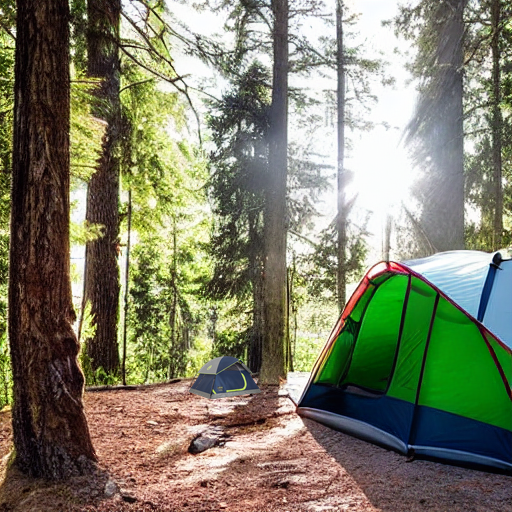

In [16]:
def main():
    from google.colab import files
    uploaded = files.upload()

    if uploaded:
        image_path = list(uploaded.keys())[0]
        output_path = './generated_output.png'

        # Generate the composite image
        final_image = generate_image(image_path, output_path)

        if final_image:
            from IPython.display import Image as IPImage, display
            display(IPImage(output_path))

# Run the main process
if __name__ == "__main__":
    main()


# **Task 2**  


In [25]:
# Create video with zoom-out effect using the generated image
def create_video_from_image(image_path, output_video_path, video_fps=10, video_duration=5):
    # Load the image using OpenCV
    original_image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    # Convert the image from RGBA to BGR
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGBA2BGR)
    height, width, _ = original_image.shape

    # Create frames for the video
    frames = []
    for i in range(1, video_fps * video_duration + 1):
        scale_factor = 1 + i * 0.05  # Zoom out incrementally
        resized_image = cv2.resize(original_image, (int(width * scale_factor), int(height * scale_factor)))

        # Crop the center part to maintain the same resolution
        center_y, center_x = resized_image.shape[0] // 2, resized_image.shape[1] // 2
        cropped_image = resized_image[
            center_y - height // 2:center_y + height // 2,
            center_x - width // 2:center_x + width // 2
        ]

        frames.append(cropped_image)

    # Write frames to video file
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(str(output_video_path), fourcc, video_fps, (width, height))

    for frame in frames:
        video_writer.write(frame)

    video_writer.release()
    print(f"Video saved at {output_video_path}")

In [26]:
!pip install opencv-python
import cv2

output_video_path = './output_video.mp4'
final_image_path = "/content/generated_output.png" # Changed variable name to final_image_path

# If the image generation is successful, generate the video
if final_image_path is not None:
    create_video_from_image(final_image_path, output_video_path)  # Pass the image path

Video saved at ./output_video.mp4
